## Imports

In [2]:
import kagglehub
import cv2
import numpy as np
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import Sequential, Dropout, Linear

import torchvision.models as models
from torchvision.models import ViT_B_16_Weights
from torchvision.models import ViT_L_16_Weights
from torchvision import transforms

import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Dataset

In [3]:
# preprocesses images and creates dataset with images and labels
class MammogramDataset(Dataset):
    def __init__(self, dataframe, root_dir, valid_folders, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.valid_folders = valid_folders

    def preprocess_image(self, image):
        # Preprocessing steps
        image = histogram_equalization(image)
        image = adjust_contrast(image)
        image = normalize_per_image(image)
        image = sharpen_image(image)
        return image

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # attributing labels to images
        cropped_path = row['cropped image file path']
        parts = cropped_path.split('/')
        folder_name = parts[2]

        folder_path = os.path.join(self.root_dir, folder_name)

        if not os.path.isdir(folder_path):
            print(f"warning: folder not found: {folder_path}, skipping")
            return self.__getitem__((idx + 1) % len(self))

        img_file = None
        for file in os.listdir(folder_path):
            if file.endswith('.jpg'):
                img_file = file
                break

        if img_file is None:
            raise FileNotFoundError(f"No .jpg image found in folder: {folder_path}")

        img_path = os.path.join(folder_path, img_file)


        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(image)

        label = 0 if (row['pathology'] == 'BENIGN' or row['pathology'] == 'BENIGN_WITHOUT_CALLBACK') else 1

        return image, label


## Preprocessing Functions

In [4]:
# preprocessing
def histogram_equalization(image):
    return cv2.equalizeHist(image)

def adjust_contrast(image, alpha=1.5, beta=0):
    return cv2.convertScaleAbs(image, alpha, beta)

def normalize_per_image(image):
    mean = np.mean(image, axis=(0,1), dtype=np.float32)
    std = np.std(image, axis=(0,1), dtype=np.float32)
    image = (image - mean) / std
    return image

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, 1, 0]])
    return cv2.filter2D(image, -1, kernel)


## Helper Functions

In [5]:
# helper function to calculate metrics like f1 score and print them
def evaluate_model_metrics(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)  # Get the index of the highest logit
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # calculating metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("\nClassification Report:\n")
    print(report)

# filter folders (get rid of masks and zoomed in images)
def filter_folders(root_dir):

    valid_folders = []
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        if os.path.isdir(folder_path):
            if not any(file.startswith('2') for file in os.listdir(folder_path)):
                valid_folders.append(folder_path)

    print(f"Succesfully validated folders")
    return valid_folders

# helper function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, device, class_names):
      model.eval()
      all_preds = []
      all_labels = []

      with torch.no_grad():
          for images, labels in dataloader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, preds = outputs.max(1)  # Get the index of the highest logit
              all_preds.extend(preds.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

      # calculating confusion matrix
      cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

      # plotting it
      disp.plot(cmap=plt.cm.Blues, values_format='d')
      plt.title('Confusion Matrix')
      plt.show()


# helper function to plot metrics
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
      epochs = range(1, len(train_losses) + 1)

      # plot training and validation loss
      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_losses, label='Training Loss')
      plt.plot(epochs, val_losses, label='Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title('Training and Validation Loss')
      plt.legend()

      # plot train and val accuracy
      plt.subplot(1, 2, 2)
      plt.plot(epochs, train_accuracies, label='Training Accuracy')
      plt.plot(epochs, val_accuracies, label='Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.legend()

      plt.tight_layout()
      plt.show()


## Run Vision Transformer Model

Succesfully validated folders
Loaded pretrained model
Using device: cuda
Epoch 1/30, Train Loss: 0.740733617338641, Train Acc: 45.41%, Val Loss: 0.7052011787891388, Val Acc: 50.43%, Time: 55.20 seconds
New best model saved with val accuracy: 50.43%
Epoch 2/30, Train Loss: 0.6918418674633421, Train Acc: 52.62%, Val Loss: 0.6935001611709595, Val Acc: 53.04%, Time: 46.52 seconds
New best model saved with val accuracy: 53.04%
Epoch 3/30, Train Loss: 0.6618286083484518, Train Acc: 57.86%, Val Loss: 0.6684777364134789, Val Acc: 56.52%, Time: 46.27 seconds
New best model saved with val accuracy: 56.52%
Epoch 4/30, Train Loss: 0.6597663842398545, Train Acc: 59.17%, Val Loss: 0.6392271891236305, Val Acc: 66.09%, Time: 44.01 seconds
New best model saved with val accuracy: 66.09%
Epoch 5/30, Train Loss: 0.6584576923271706, Train Acc: 58.08%, Val Loss: 0.6412274986505508, Val Acc: 60.00%, Time: 43.62 seconds
Epoch 6/30, Train Loss: 0.6360855534158903, Train Acc: 61.79%, Val Loss: 0.630415067076683

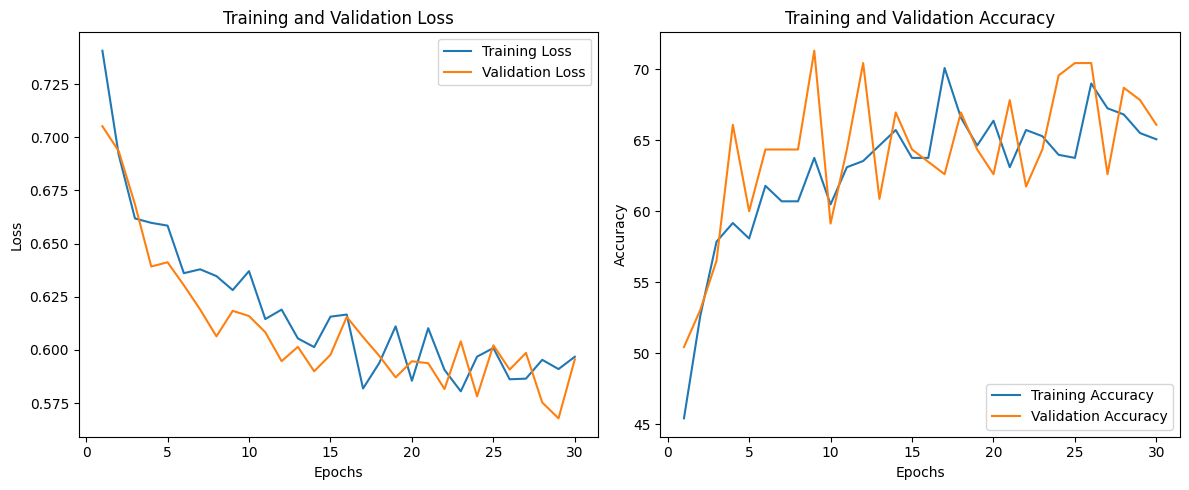

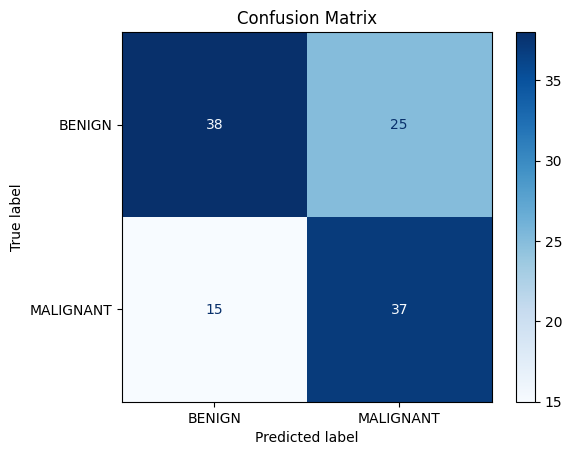


Classification Report:

              precision    recall  f1-score   support

      BENIGN     0.7037    0.6032    0.6496        63
   MALIGNANT     0.5902    0.6923    0.6372        52

    accuracy                         0.6435       115
   macro avg     0.6469    0.6477    0.6434       115
weighted avg     0.6524    0.6435    0.6440       115



In [10]:
def main():
    # loading csv files
    calc_train = pd.read_csv('dataset/csv/calc_case_description_train_set.csv')
    mass_train = pd.read_csv('dataset/csv/mass_case_description_train_set.csv')
    calc_test = pd.read_csv('dataset/csv/calc_case_description_test_set.csv')
    mass_test = pd.read_csv('dataset/csv/mass_case_description_test_set.csv')

    # combining to get full train and test
    combined_train = pd.concat([calc_train, mass_train], ignore_index=True)
    combined_test = pd.concat([calc_test, mass_test], ignore_index=True)

    # sampling to test
    combined_train = combined_train.sample(frac=0.2, random_state=42)
    combined_test = combined_test.sample(frac=0.2, random_state=42)

    # define transforms
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.5)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.RandomAffine(10),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # crop and resize images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    root_dir = 'dataset/jpeg'
    valid_folders = filter_folders(root_dir)

    train_data, val_data = train_test_split(
        combined_train,
        test_size=0.2,
        random_state=42,
        stratify=combined_train['pathology']
    )

    # create data sets and data loader
    train_dataset = MammogramDataset(train_data, root_dir, valid_folders, transform=transform)
    val_dataset = MammogramDataset(val_data, root_dir, valid_folders, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)

    # load pretrained model
    model = models.vit_l_16(weights=ViT_L_16_Weights.IMAGENET1K_V1)

    num_features = model.heads.head.in_features
    model.heads.head = Sequential(
        Dropout(p=0.2),
        Linear(num_features, 2)
    )

    print(f"Loaded pretrained model")

    # freezing all layers
    for param in model.parameters():
        param.requires_grad = False

    # unfreezing head for fine-tuning bc we're using pretrained model
    for param in model.heads.head.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)

    # using dynamic weighting for each sample
    combined_train['pathology'] = combined_train['pathology'].replace(
        {'BENIGN_WITHOUT_CALLBACK': 'BENIGN'}
    )

    combined_test['pathology'] = combined_test['pathology'].replace(
        {'BENIGN_WITHOUT_CALLBACK': 'BENIGN'}
    )

    # finding first weighting for model
    class_counts = combined_train['pathology'].value_counts()
    total_sample = len(combined_train)
    class_weights = [total_sample / (2 * count) for count in class_counts]
    weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    epochs = 30
    best_val_accuracy_l16 = 0.0

    # training and evaluating
    for epoch in range(epochs):
        # changing weights for each epoch
        train_labels = [label for _, label in train_loader.dataset]
        class_counts = pd.Series(train_labels).value_counts()
        total_sample = len(train_labels)
        class_weights = [total_sample / (2 * count) for count in class_counts]
        weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        epoch_start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Train Acc: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss}, Val Acc: {val_accuracy:.2f}%, Time: {epoch_duration:.2f} seconds")

        if val_accuracy > best_val_accuracy_l16:
            best_val_accuracy_l16 = val_accuracy
            torch.save(model.state_dict(), f'yippie.pth')
            print(f"New best model saved with val accuracy: {val_accuracy:.2f}%")

    torch.save(model.state_dict(), 'vit_l_16_mammogram.pth')

    # visualizations
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

    class_names = ['BENIGN', 'MALIGNANT']
    plot_confusion_matrix(model, val_loader, device, class_names)

    evaluate_model_metrics(model, val_loader, device, class_names)

if __name__ == '__main__':
    main()